In [1]:
import numpy as np
import os
import pickle
from IMDBModel import IMDBModel
from embedding import Embedding
from keras.preprocessing import sequence
import time
from glove_utils import load_embedding
from data_utils import IMDBDataset
from pprint import pprint
from explainers import SBE, LIMEExplainer
from textblob import TextBlob
from parsers import StanfordParser
from utils import preprocess_text, get_tokens
from collections import OrderedDict
from copy import deepcopy
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

## Load GloVe vectors used by the model

In [3]:
# Load main vectors
print('Loading GLoVe...')
start_time = time.time()
MODEL_EMBEDDING_FILENAME = 'data/glove.6B.100d.txt'
m_word2index, m_index2word, m_index2embedding = load_embedding(MODEL_EMBEDDING_FILENAME)
print('Loaded %s word vectors in %f seconds' % (len(m_word2index), time.time()-start_time))
model_embedding = Embedding(m_word2index, m_index2word, m_index2embedding)

Loading GLoVe...
Loaded 400002 word vectors in 16.880470 seconds


### Load model

In [4]:
# Load model
imdb_model = IMDBModel('models/lstm_model.h5', model_embedding)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### Load IMDB data

In [5]:
# Load data
maxlen = 200
batch_size = 32
print('Loading data...')
(train_text, x_train, y_train), (test_text, x_test, y_test) = IMDBDataset.load_data()
x_train = sequence.pad_sequences(x_train, maxlen=maxlen, padding = 'pre', truncating = 'pre')
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, padding = 'pre', truncating = 'pre')
print('Data loaded.')


Loading data...
Data loaded.


## Create Explainer

In [6]:
sbe = SBE(imdb_model, m = 1000, SIGMA = 2/5)
lime_explainer = LIMEExplainer(imdb_model, nsamples = 1000)

In [7]:
positive_text = preprocess_text(test_text[8451])
positive_text

'very well done acting and directing . this is a cross between the last don and godfather 2 . one large plus for this production is that it is claimed to be a true story of joseph bonanno . with a better music score to create mood , it could have been a rival for both godfather movies .'

In [8]:
imdb_model.predict(positive_text)

0.87889206

In [9]:
negative_text =  preprocess_text(test_text[12506])
negative_text

'when i voted my 1 for this film i noticed that 75 people voted the same out of 146 total votes . that means that half the people that voted for this film feel its truly terrible . i saw this not long ago at a film festival and i was really unimpressed by its poor execution . the cinematography is unwatchable , the sound is bad , the story is cut and pasted from many other movies , and the acting is dreadful . this movie is basically a poor rip - off of three other films . no wonder this was never released in the usa .'

In [10]:
imdb_model.predict(negative_text)

0.0016409671

## Plotting Functions

In [11]:
def plot_importance(feature_name, ranked_tokens, tokens_ranking, values, display_count):
    data = {feature_name : ranked_tokens[:display_count], "importance": values[tokens_ranking][:display_count]}
    df = pd.DataFrame(data)
    # plot
    sns.set_color_codes("deep")
    ax = sns.barplot(y=df.index, x ="importance", data=df, orient = 'h', color="b", ci = None)
    ax.set_yticklabels(df[feature_name])
    ax.set_ylabel(feature_name)
    return ax

In [12]:
def plot_sentiment(feature_name, ranked_tokens, tokens_ranking, values, display_count):
    data = {feature_name : ranked_tokens[:display_count//2] + ranked_tokens[-display_count//2:], 
    "sentiment": values[tokens_ranking][:display_count//2].tolist() + values[tokens_ranking][-display_count//2:].tolist()}
    # order from most positive to most negative for barplot
    data[feature_name] = list(reversed(data[feature_name]))
    data["sentiment"] = list(reversed(data["sentiment"]))
    df = pd.DataFrame(data)
    colors = ['r' if value < 0 else 'g' for value in df.sentiment]
    # plot
    sns.set_color_codes("pastel")
    ax = sns.barplot(y=df.index, x ="sentiment", data=df, orient = 'h', palette=colors, ci = None)
    ax.set_yticklabels(df[feature_name])
    ax.set_ylabel(feature_name)
    return ax 

In [13]:
def save_plot(ax, fig_name, save_path = 'figures/explanations/'):
    fig = ax.get_figure()
    fig.savefig(save_path+fig_name, dpi = 200, bbox_inches = 'tight')

## Word Level Explanations

### Positive Sentiment Text

In [ ]:
# Importance ranking
words_ranking , ranked_words , values  = sbe.explain_text_words(positive_text, rank_by_importance = True )
ax = plot_importance('word', ranked_words, words_ranking, values, display_count = 10)

In [156]:
save_plot(ax,'sbewordpositiveimportance.png')

In [ ]:
# Sentiment ranking
words_ranking , ranked_words , values  = sbe.explain_text_words(positive_text, rank_by_importance = False)
ax = plot_sentiment('word', ranked_words, words_ranking, values, display_count = 20)

In [158]:
save_plot(ax,'sbewordpositivesentiment.png')

In [149]:
word_ranking, ranked_words, weights, explanation = lime_explainer.explain(positive_text, 20, return_weights= True)

In [ ]:
ax = lime_explainer.plot_weights(weights,explanation)

In [153]:
save_plot(ax, 'limewordpositive.png')

### Negative Sentiment Text

In [ ]:
# Importance ranking
words_ranking , ranked_words , values  = sbe.explain_text_words(negative_text, rank_by_importance = True )
ax = plot_importance('word', ranked_words, words_ranking, values, display_count = 10)

In [173]:
save_plot(ax,'sbewordnegativeimportance.png')

In [ ]:
# Sentiment ranking
words_ranking , ranked_words , values  = sbe.explain_text_words(negative_text, rank_by_importance = False)
ax = plot_sentiment('word', ranked_words, words_ranking, values, display_count = 20)

In [176]:
save_plot(ax,'sbewordnegativesentiment.png')

In [186]:
word_ranking, ranked_words, weights, explanation = lime_explainer.explain(negative_text, 20, return_weights= True)

In [ ]:
ax = lime_explainer.plot_weights(weights,explanation)

In [191]:
save_plot(ax,'limewordnegative.png')

## Sentence Level Explanations

In [93]:
def get_sentences(text):
    sentences = list(map(str,TextBlob(text).sentences))
    return sentences

### Positive Text

In [ ]:
# Importance Ranking
sentence_ranking , ranked_sentences, values = sbe.explain_tokens(get_sentences(positive_text), rank_by_importance = True)
ax = plot_importance('sentence', ranked_sentences, sentence_ranking, values, display_count = len(sentence_ranking))

In [ ]:
# Sentiment Ranking
sentence_ranking , ranked_sentences, values = sbe.explain_tokens(get_sentences(positive_text), rank_by_importance = False)
ax = plot_sentiment('sentence', ranked_sentences, sentence_ranking, values, display_count = len(sentence_ranking))

In [193]:
save_plot(ax, 'sbesentencepositivesentiment.png')

### Negative Sentiment Text

In [ ]:
# Importance ranking
sentence_ranking , ranked_sentences, values = sbe.explain_tokens(get_sentences(negative_text), rank_by_importance = True)
ax = plot_importance('sentence', ranked_sentences, sentence_ranking, values, display_count = len(sentence_ranking))

In [ ]:
# Sentiment Ranking
sentence_ranking , ranked_sentences, values = sbe.explain_tokens(get_sentences(negative_text), rank_by_importance = False)
ax = plot_sentiment('sentence', ranked_sentences, sentence_ranking, values, display_count = len(sentence_ranking))

In [292]:
save_plot(ax, 'sbesentencenegativesentiment.png')

In [253]:
imdb_model.predict('that means that half the people that voted for this film feel its truly terrible .')

0.06043263

## Phrase Level Explanations

In [55]:
def get_phrases(text):
    parser = StanfordParser()
    sentences = TextBlob(text).sentences
    phrases = []
    for sentence in sentences:
        sentence = str(sentence)
        phrases_in_sentence = parser.get_phrases(sentence, split_tags = ['S', 'SBAR','.'])
        phrases.extend(phrases_in_sentence)
    parser.close()
    return phrases

### Positive Sentiment Text

In [67]:
positive_text_phrases = get_phrases(positive_text)
print("Phrases: ", positive_text_phrases)

parse string:  (ROOT
  (NP
    (NP (RB very) (RB well))
    (VP (VBN done)
      (S
        (VP (VBG acting)
          (CC and)
          (VBG directing))))
    (. .)))
parse string:  (ROOT
  (S
    (NP (DT this))
    (VP (VBZ is)
      (NP
        (NP (DT a) (NN cross))
        (PP (IN between)
          (NP
            (S
              (NP (DT the) (JJ last))
              (VP (VB don)))
            (CC and)
            (NP
              (NP (NN godfather))
              (NP (CD 2)))))))
    (. .)))
parse string:  (ROOT
  (S
    (NP
      (NP (CD one))
      (ADJP (JJ large)
        (PP (CC plus)
          (PP (IN for)
            (NP (DT this) (NN production))))))
    (VP (VBZ is)
      (SBAR (IN that)
        (S
          (NP (PRP it))
          (VP (VBZ is)
            (VP (VBN claimed)
              (S
                (VP (TO to)
                  (VP (VB be)
                    (NP
                      (NP (DT a) (JJ true) (NN story))
                      (PP (IN of)
         

In [ ]:
# Importance Ranking
phrase_ranking , ranked_phrases, values = sbe.explain_tokens(positive_text_phrases, rank_by_importance = True)
ax = plot_importance('phrase', ranked_phrases, phrase_ranking, values, display_count = len(phrase_ranking))

In [ ]:
# Sentiment Ranking
phrase_ranking , ranked_phrases, values = sbe.explain_tokens(positive_text_phrases, rank_by_importance = False)
ax = plot_sentiment('phrase', ranked_phrases, phrase_ranking, values, display_count = len(phrase_ranking))

### Negative Sentiment Text

In [71]:
negative_text_phrases = get_phrases(negative_text)
print("Phrases: ", negative_text_phrases)

parse string:  (ROOT
  (S
    (SBAR
      (WHADVP (WRB when))
      (S
        (NP (FW i))
        (VP (VBD voted)
          (NP (PRP$ my))
          (NP
            (NP (CD 1))
            (PP (IN for)
              (NP (DT this) (NN film)))))))
    (NP (FW i))
    (VP (VBD noticed)
      (SBAR (IN that)
        (S
          (NP (CD 75) (NNS people))
          (VP (VBD voted)
            (NP (DT the) (JJ same))
            (PP (IN out))
            (PP (IN of)
              (NP (CD 146) (JJ total) (NNS votes)))))))
    (. .)))
parse string:  (ROOT
  (S
    (NP (DT that))
    (VP (VBZ means)
      (SBAR (IN that)
        (S
          (NP
            (NP (PDT half) (DT the) (NNS people))
            (SBAR
              (WHNP (WDT that))
              (S
                (VP (VBD voted)
                  (PP (IN for)
                    (NP (DT this) (NN film)))))))
          (VP (VB feel)
            (S
              (NP (PRP$ its))
              (ADJP (RB truly) (JJ terrible)))))))
    

In [ ]:
# Importance Ranking
phrase_ranking , ranked_phrases, values = sbe.explain_tokens(negative_text_phrases, rank_by_importance = True)
ax = plot_importance('phrase', ranked_phrases, phrase_ranking, values, display_count = len(phrase_ranking))

In [ ]:
# Sentiment Ranking
phrase_ranking , ranked_phrases, values = sbe.explain_tokens(negative_text_phrases, rank_by_importance = False)
ax = plot_sentiment('phrase', ranked_phrases, phrase_ranking, values, display_count = len(phrase_ranking))

In [ ]:
imdb_model.predict("the cinematography is unwatchable.")

## Compare SBE with LIME using pseudo-adversarial example generation as proxy

In [14]:
# predicted probabilities
p_hat = imdb_model.model.predict(x_test, batch_size = 32).flatten()
# predicted_ classes
y_hat = np.where(p_hat >= 0.5, 1, 0)
# indexes where the predictions were wrong
wrong_indexes = np.where(y_hat != y_test)[0]
# indexes where the prediction were correct
correct_indexes = np.where(y_hat == y_test)[0]

In [15]:
def get_success_rate(adv_dists):
    adv_dists = np.array(adv_dists)
    successful_indexes = np.where(adv_dists>0)[0]
    success_rate = len(successful_indexes) / len(adv_dists)
    return success_rate

def get_success_rate_at_threshold(adv_dists, threshold):
    adv_dists = np.array(adv_dists)
    successful_indexes = np.where((adv_dists>0) & (adv_dists <= threshold))[0]
    success_rate = len(successful_indexes) / len(adv_dists)
    return success_rate

def get_success_rates_at_thresholds(adv_dists, thresholds):
    success_rates = dict()
    for threshold in thresholds:
        success_rate_at_threshold = get_success_rate_at_threshold(adv_dists,threshold)
        success_rates[threshold] = success_rate_at_threshold
    return success_rates

In [16]:
MAX_DIST = 0.3  # not more than 30% of words should be removed
def create_adversary(model, tokens, token_ranking, y):
    '''
    Generate a pseudo-adversarial example by iteratively removing the word tokens
    that contributed the most to class y. These are given by token_ranking.
    '''
    max_perturbation_size = int(MAX_DIST*len(tokens))
    for i in range(max_perturbation_size):
        kept_positions = sorted(token_ranking[i+1:])
        adv_tokens = np.array(tokens)[kept_positions].tolist()
        adv_text = ' '.join(adv_tokens)
        if model.predict_class(adv_text) !=y :
            print("Attack succeeded by dropping %d words" % (i+1))
            removed_tokens = [tokens[j]  for j in token_ranking[:i+1]]
            return adv_text, i+1, removed_tokens
    print("Attack failed")
    return ' '.join(tokens), 0, []
        

In [ ]:
np.random.seed(23)
sample_size = 500
sampled_indexes = np.random.choice(correct_indexes, sample_size, replace = False)
sbe_adv_dists = []
lime_adv_dists = []
for (i,index) in enumerate(sampled_indexes):
    print("#",i," index = ", index, flush = True)
    text = imdb_model.preprocess_text(test_text[index])
    y = imdb_model.predict_class(text)
    tokens = get_tokens(text)
    print("Original prediction = ", imdb_model.predict(text))
    print()
    print(text)
    print()
    ########## SBE explanation
    print("Getting SBE explanation...")
    words_ranking, ranked_words, values = sbe.explain_tokens(tokens, rank_by_importance = False)
    if y == 1:
        words_ranking = np.flip(words_ranking)
        ranked_words = list(reversed(ranked_words))
    adv_text , perturbation_size, removed_words = create_adversary(imdb_model, tokens, words_ranking, y)
    print("Perturbation size = ", perturbation_size, ' out of  ', len(tokens), ' words.')
    sbe_adv_dist = perturbation_size / len(tokens)
    print("SBE adversarial distance = ", sbe_adv_dist)
    sbe_adv_dists.append(sbe_adv_dist)
    print("Removed words: ", removed_words)
    print("New prediction = ", imdb_model.predict(adv_text))    
    
    ########### LIME explanation
    print("Getting LIME explanation...")
    _, _ , weights, _ = lime_explainer.explain(text,len(tokens), return_weights= True)
    # order weights from smallest to largest (most negative to most positive) instead of by absolute value
    weights =  sorted(weights.items(),key = lambda x: x[1]) 
    words_ranking = [word for (word,weight) in weights]
    ranked_words = [tokens[j] for j in words_ranking]
    if y == 1:
        words_ranking = np.flip(words_ranking)
        ranked_words = list(reversed(ranked_words))
    adv_text , perturbation_size, removed_words = create_adversary(imdb_model, tokens, words_ranking, y)
    print("LIME Perturbation size = ", perturbation_size, ' out of  ', len(tokens), ' words.')
    lime_adv_dist = perturbation_size / len(tokens)
    print("LIME adversarial distance = ", lime_adv_dist)
    lime_adv_dists.append(lime_adv_dist)
    print("Removed words: ", removed_words)
    print("New prediction = ", imdb_model.predict(adv_text))   
    
    
    ### Monitor current success rates
    if i % 20 == 0 :
        thresholds = np.arange(0.05, MAX_DIST+0.05, 0.05)
        current_sbe_success_rates = get_success_rates_at_thresholds(sbe_adv_dists,thresholds)
        print("Current SBE success rates: ")
        print(current_sbe_success_rates)
        current_lime_success_rates = get_success_rates_at_thresholds(lime_adv_dists,thresholds)
        print("Current LIME success rates: ")
        print(current_lime_success_rates)
    
    print(80*'-')
    
    
    

### Save Results

In [19]:
experiment_handle = 'sbevslime'
dir_name = 'results/'

In [ ]:
# Create directory if it does not exits
if not os.path.exists(dir_name):
    print("Created directory")
    os.mkdir(dir_name)
# Pickle attack results
f = open(dir_name + experiment_handle+'.pickle', 'wb')
pickle.dump((sbe_adv_dists,lime_adv_dists),f)
f.close()

### Load Results

In [20]:
f = open(dir_name + experiment_handle+'.pickle', 'rb')
(sbe_adv_dists, lime_adv_dists) = pickle.load(f)
f.close()

### Visualize Results

In [21]:
sbe_success_rate = get_success_rate(sbe_adv_dists)
print("SBE success rate: ")
print(sbe_success_rate)
print("LIME success rate: ")
lime_success_rate = get_success_rate(lime_adv_dists)
print(lime_success_rate)

SBE success rate: 
0.956
LIME success rate: 
0.84


In [22]:
thresholds = np.arange(0.05, MAX_DIST+0.05, 0.05)
sbe_success_rates = get_success_rates_at_thresholds(sbe_adv_dists,thresholds)
print(sbe_success_rates)
lime_success_rates = get_success_rates_at_thresholds(lime_adv_dists,thresholds)
print(lime_success_rates)

{0.05: 0.614, 0.1: 0.796, 0.15000000000000002: 0.864, 0.2: 0.916, 0.25: 0.938, 0.3: 0.956}
{0.05: 0.484, 0.1: 0.642, 0.15000000000000002: 0.734, 0.2: 0.78, 0.25: 0.818, 0.3: 0.84}


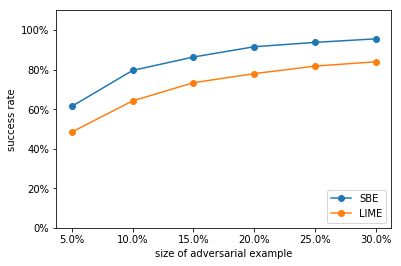

In [23]:
# Plot success rates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import PercentFormatter
plt.xlabel('size of adversarial example')
plt.ylabel('success rate')
plt.ylim((0,1.1))
plt.plot(sbe_success_rates.keys(), sbe_success_rates.values(), marker='o', label = 'SBE')
plt.plot(lime_success_rates.keys(), lime_success_rates.values(), marker='o', label = 'LIME')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='lower right')
if not os.path.exists('figures/explanations/'):
    os.mkdir('figures/explanations/')
plt.savefig('figures/explanations/SBEvsLIME.png', dpi=300)
plt.show()